In [1]:
import pandas as pd

def load_data(path=r"c:\Users\hp\Pictures\AlphaCare Insurance Solutions (ACIS)\alpha-care-risk-analytics\data\raw\insurance_data_feb2014_aug2015.txt"):
    df = pd.read_csv(path)
    print(f"Data loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")
    return df

def basic_info(df):
    print("\nData Types & Missing Values:")
    print(df.info())
    print("\nMissing Values (%):")
    print(df.isnull().mean() * 100)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Load data
df = pd.read_csv(r"c:\Users\hp\Pictures\AlphaCare Insurance Solutions (ACIS)\alpha-care-risk-analytics\data\raw\insurance_data_feb2014_aug2015.txt", delimiter='|', on_bad_lines='skip')
# Basic cleaning
df['TransactionMonth'] = pd.to_datetime(df['TransactionMonth'])
df['PostalCode'] = df['PostalCode'].astype(str)
df['TotalPremium'] = df['TotalPremium'].abs()
df['TotalClaims'] = df['TotalClaims'].abs()

# 1. Overall Loss Ratio
df['LossRatio'] = df['TotalClaims'] / df['TotalPremium'].replace(0, np.nan)
overall_loss_ratio = df['TotalClaims'].sum() / df['TotalPremium'].sum()
print(f"Overall Portfolio Loss Ratio: {overall_loss_ratio:.3f}")

Overall Portfolio Loss Ratio: 1.047


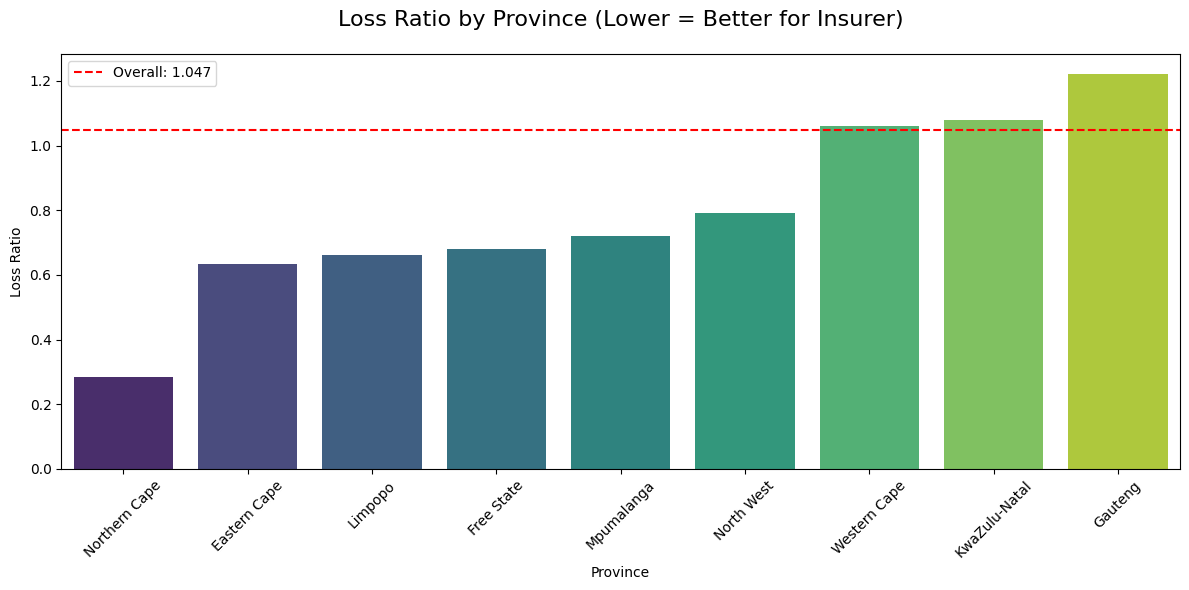

In [5]:
# Loss Ratio by Province
province_lr = df.groupby('Province').agg({
    'TotalClaims': 'sum',
    'TotalPremium': 'sum'
}).assign(LossRatio=lambda x: x['TotalClaims']/x['TotalPremium']).sort_values('LossRatio')

# Plot 1: Beautiful Loss Ratio by Province
plt.figure(figsize=(12,6))
sns.barplot(data=province_lr.reset_index(), x='Province', y='LossRatio', palette='viridis')
plt.title('Loss Ratio by Province (Lower = Better for Insurer)', fontsize=16, pad=20)
plt.xticks(rotation=45)
plt.ylabel('Loss Ratio')
plt.axhline(overall_loss_ratio, color='red', linestyle='--', label=f'Overall: {overall_loss_ratio:.3f}')
plt.legend()
plt.tight_layout()
plt.savefig(r'C:\Users\hp\Pictures\AlphaCare Insurance Solutions (ACIS)\alpha-care-risk-analytics\output\loss_ratio_by_province.png', dpi=300)
plt.show()

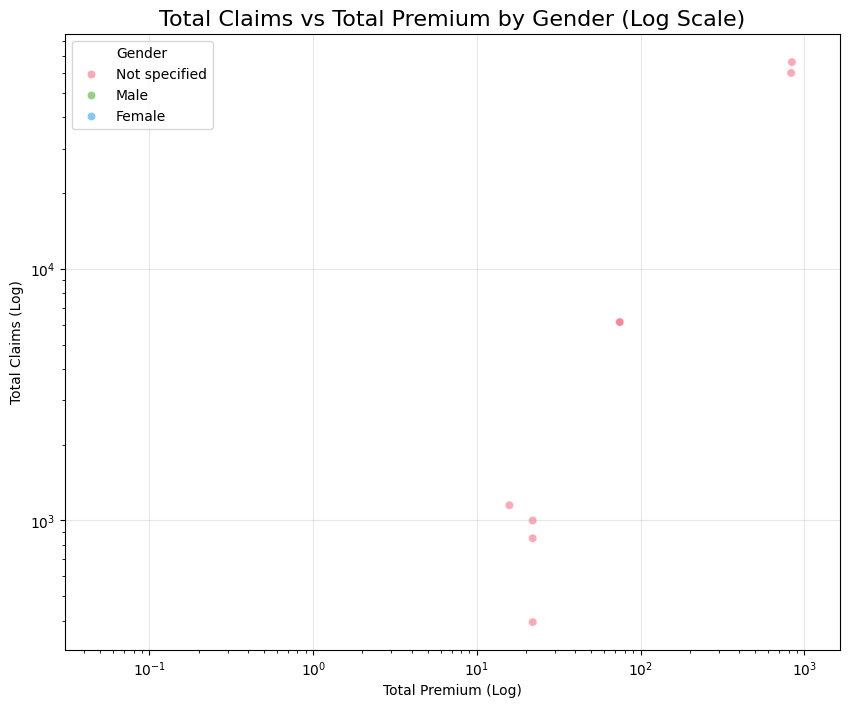

In [7]:
plt.figure(figsize=(10,8))
sns.scatterplot(data=df.sample(5000), x='TotalPremium', y='TotalClaims',
                hue='Gender', alpha=0.6, palette='husl')
plt.xscale('log')
plt.yscale('log')
plt.title('Total Claims vs Total Premium by Gender (Log Scale)', fontsize=16)
plt.xlabel('Total Premium (Log)')
plt.ylabel('Total Claims (Log)')
plt.legend(title='Gender')
plt.grid(True, alpha=0.3)
plt.savefig(r'C:\Users\hp\Pictures\AlphaCare Insurance Solutions (ACIS)\alpha-care-risk-analytics\output\claims_vs_premium_gender.png', dpi=300)
plt.show()

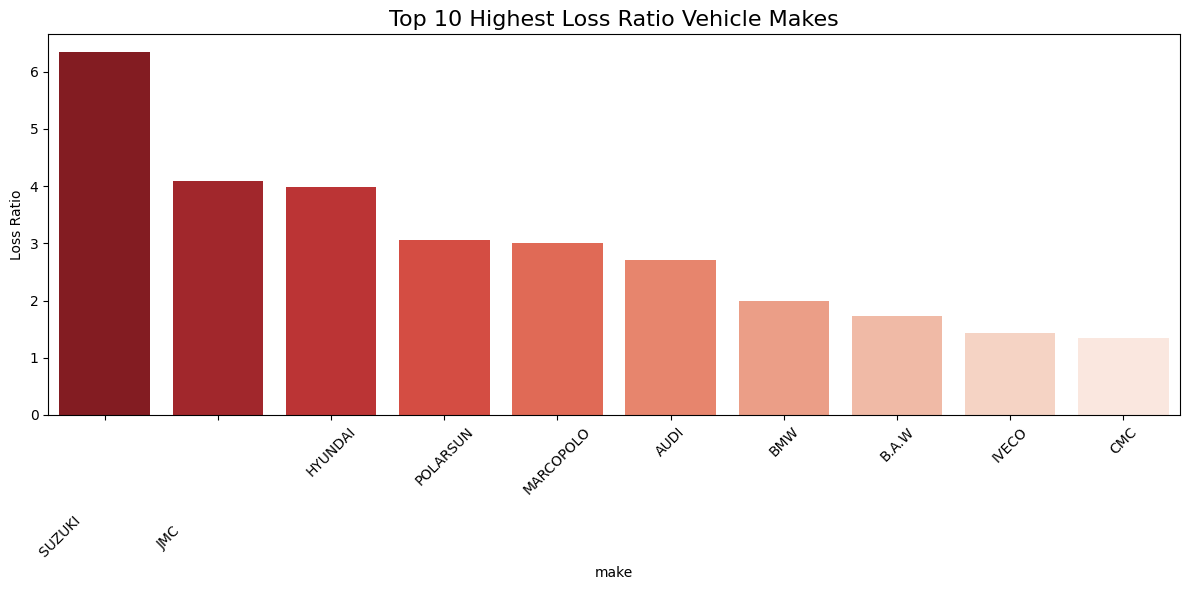

In [10]:
# Clean column names
df.columns = df.columns.str.strip()

# Basic cleaning and data preparation
df['TransactionMonth'] = pd.to_datetime(df['TransactionMonth'])
df['PostalCode'] = df['PostalCode'].astype(str)
df['TotalPremium'] = df['TotalPremium'].abs()
df['TotalClaims'] = df['TotalClaims'].abs()

# Calculate make-wise risk analysis using the correct column name 'make'
make_risk = df.groupby('make').agg({
    'TotalClaims': 'sum',
    'TotalPremium': 'sum',
    'PolicyID': 'count'  # Count of policies per make
}).assign(
    LossRatio=lambda x: x['TotalClaims'] / x['TotalPremium'].replace(0, np.nan),  # Avoid division by zero
    AvgClaim=lambda x: x['TotalClaims'] / x['PolicyID']  # Average claim per policy
).sort_values('LossRatio', ascending=False).head(10)

# Plotting the highest loss ratio vehicle makes
plt.figure(figsize=(12, 6))
sns.barplot(data=make_risk.reset_index(), x='make', y='LossRatio', palette='Reds_r')
plt.title('Top 10 Highest Loss Ratio Vehicle Makes', fontsize=16)
plt.xticks(rotation=45)
plt.ylabel('Loss Ratio')
plt.tight_layout()  # Adjust layout
plt.savefig(r'C:\Users\hp\Pictures\AlphaCare Insurance Solutions (ACIS)\alpha-care-risk-analytics\output\top_risky_makes.png', dpi=300)

In [11]:
from scipy import stats
import pingouin as pg

def test_province_risk_difference(df):
    provinces = df['Province'].value_counts().head(6).index
    groups = [df[df['Province'] == p]['TotalClaims'] / df[df['Province'] == p]['TotalPremium'] for p in provinces]
    f_stat, p_val = stats.f_oneway(*groups)
    print(f"Province Risk Difference Test: F={f_stat:.2f}, p={p_val:.2e}")
    return p_val < 0.05

def test_gender_risk_difference(df):
    male = df[df['Gender'] == 'Male']['TotalClaims'] / df[df['Gender'] == 'Male']['TotalPremium']
    female = df[df['Gender'] == 'Female']['TotalClaims'] / df[df['Gender'] == 'Female']['TotalPremium']
    t_stat, p_val = stats.ttest_ind(male.dropna(), female.dropna(), equal_var=False)
    print(f"Gender Risk Difference: t={t_stat:.2f}, p={p_val:.2e}")
    return p_val < 0.05

# Run tests
print("Hypothesis Testing Results:")
print("H0: No risk differences across provinces →", "REJECTED" if test_province_risk_difference(df) else "Failed to reject")
print("H0: No risk difference between men and women →", "REJECTED" if test_gender_risk_difference(df) else "Failed to reject")

Hypothesis Testing Results:
Province Risk Difference Test: F=nan, p=nan
H0: No risk differences across provinces → Failed to reject
Gender Risk Difference: t=nan, p=nan
H0: No risk difference between men and women → Failed to reject


In [14]:
print(df.columns.tolist())

['UnderwrittenCoverID', 'PolicyID', 'TransactionMonth', 'IsVATRegistered', 'Citizenship', 'LegalType', 'Title', 'Language', 'Bank', 'AccountType', 'MaritalStatus', 'Gender', 'Country', 'Province', 'PostalCode', 'MainCrestaZone', 'SubCrestaZone', 'ItemType', 'mmcode', 'VehicleType', 'RegistrationYear', 'make', 'Model', 'Cylinders', 'cubiccapacity', 'kilowatts', 'bodytype', 'NumberOfDoors', 'VehicleIntroDate', 'CustomValueEstimate', 'AlarmImmobiliser', 'TrackingDevice', 'CapitalOutstanding', 'NewVehicle', 'WrittenOff', 'Rebuilt', 'Converted', 'CrossBorder', 'NumberOfVehiclesInFleet', 'SumInsured', 'TermFrequency', 'CalculatedPremiumPerTerm', 'ExcessSelected', 'CoverCategory', 'CoverType', 'CoverGroup', 'Section', 'Product', 'StatutoryClass', 'StatutoryRiskType', 'TotalPremium', 'TotalClaims', 'LossRatio']


['UnderwrittenCoverID', 'PolicyID', 'TransactionMonth', 'IsVATRegistered', 'Citizenship', 'LegalType', 'Title', 'Language', 'Bank', 'AccountType', 'MaritalStatus', 'Gender', 'Country', 'Province', 'PostalCode', 'MainCrestaZone', 'SubCrestaZone', 'ItemType', 'mmcode', 'VehicleType', 'RegistrationYear', 'make', 'Model', 'Cylinders', 'cubiccapacity', 'kilowatts', 'bodytype', 'NumberOfDoors', 'VehicleIntroDate', 'CustomValueEstimate', 'AlarmImmobiliser', 'TrackingDevice', 'CapitalOutstanding', 'NewVehicle', 'WrittenOff', 'Rebuilt', 'Converted', 'CrossBorder', 'NumberOfVehiclesInFleet', 'SumInsured', 'TermFrequency', 'CalculatedPremiumPerTerm', 'ExcessSelected', 'CoverCategory', 'CoverType', 'CoverGroup', 'Section', 'Product', 'StatutoryClass', 'StatutoryRiskType', 'TotalPremium', 'TotalClaims', 'LossRatio']
MAE: 86.81
R²: 0.004


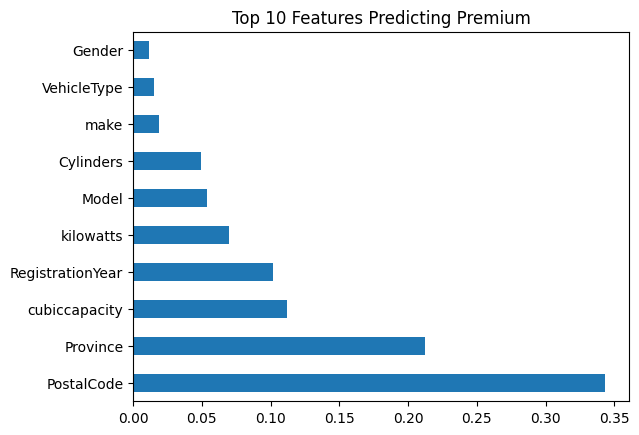

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, r2_score
import warnings

warnings.filterwarnings('ignore')

# Assume df is loaded here

# Verify columns
print(df.columns.tolist())

# Adjust the feature columns based on actual names
feature_cols = ['Province', 'PostalCode', 'VehicleType', 'make', 'Model', 
                'RegistrationYear', 'Cylinders', 'cubiccapacity', 'kilowatts',
                'bodytype', 'Gender', 'MaritalStatus']

# Create the DataFrame for modeling
df_model = df[feature_cols + ['TotalPremium']].copy()

# Encode categorical variables
for col in df_model.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col].astype(str))

X = df_model.drop('TotalPremium', axis=1)
y = df_model['TotalPremium']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
preds = model.predict(X_test)
print(f"MAE: {mean_absolute_error(y_test, preds):.2f}")
print(f"R²: {r2_score(y_test, preds):.3f}")

# Feature Importance
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
importances.head(10).plot(kind='barh', title='Top 10 Features Predicting Premium')

plt.savefig(r'C:\Users\hp\Pictures\AlphaCare Insurance Solutions (ACIS)\alpha-care-risk-analytics\output\feature_importance.png', dpi=300)
plt.show()